# Restaurant Visitor Forecasting 

This is a Restaurant Visitors dataset that was inspired by a Kaggle competition. The data considers daily visitors to four restaurants located in the United States, subject to American holidays. 

The dataset contains 478 days of restaurant data, plus an additional 39 days of holiday data for forecasting purposes.

### Loading standard libraries

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv('/Users/rahulkhandelwal/Desktop/Code/Restaurant Visitor Forecasting/RestaurantVisitors.csv',index_col='date',parse_dates=True)
df.index.freq = 'D'

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rahulkhandelwal/Desktop/Code/Restaurant Visitor Forecasting/RestaurantVisitors.csv'

### Inspecting the data

In [ ]:
df.head(10)

We notice that even though the restaurant visitor columns contain integer data, they appear as floats. This is because the bottom of the dataframe has 39 rows of NaN data to accommodate the extra holiday data we'll use for forecasting, and pandas won't allow NaN's as integers. We could leave it like this, but since we have to drop NaN values anyway, let's also convert the columns to dtype int64.

In [ ]:
df.tail()

In [ ]:
df1 = df.dropna()
df1.tail()

In [ ]:
# Change the dtype of selected columns
cols = ['rest1','rest2','rest3','rest4','total']
for col in cols:
    df1[col] = df1[col].astype(int)
df1.head()

### Plotting the time series data

In [ ]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' # we don't really need a label here

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Let us look at spikes in the number of people visiting restaurants during holidays.

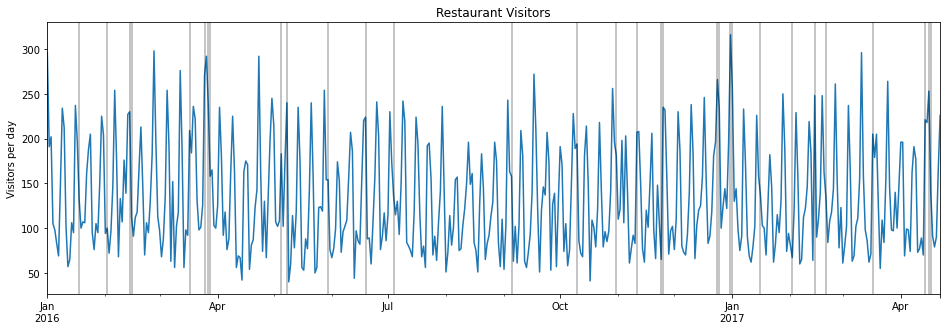

In [7]:
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='' 

ax = df1['total'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df1.query('holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

### ETS decomposition of data 

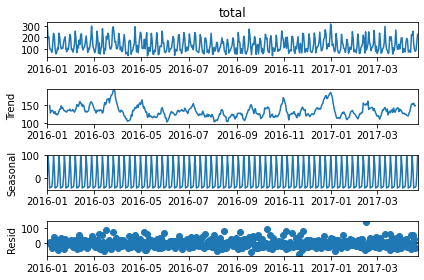

In [8]:
result = seasonal_decompose(df1['total'])
result.plot();

### Run ADF test to check if data is stationary 

In [9]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [10]:
adf_test(df1['total'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.592497
p-value                   0.000001
# lags used              18.000000
# observations          459.000000
critical value (1%)      -3.444677
critical value (5%)      -2.867857
critical value (10%)     -2.570135
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Plot ACF and PACF Plots to get idea of orders

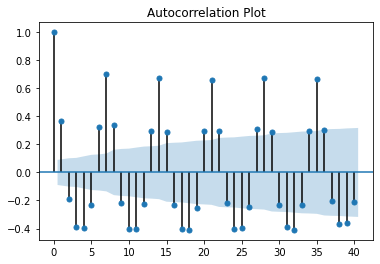

In [11]:
title = 'Autocorrelation Plot'
lags = 40
plot_acf(df1['total'],title=title,lags=lags);

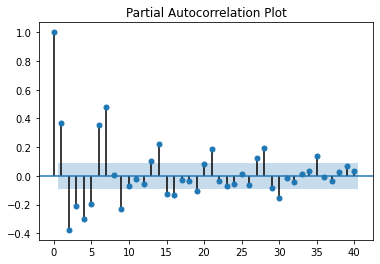

In [12]:
title = 'Partial Autocorrelation Plot'
lags = 40
plot_pacf(df1['total'],title=title,lags=lags);

The sharp cut-off at lag-1 in the PACF plot and presence of positive correlation in ACF plot at lag-1 indicates AR-1 model.

According to Duke University's Statistical website:
1. If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag at which the ACF cuts off is the indicated number of MA terms.
2. If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding an AR term to the model. The lag at which the PACF cuts off is the indicated number of AR terms.

### Run auto_arima from pmdarima to get orders 

In [22]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df1['total'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2388.674
Date:                   Wed, 18 Nov 2020   AIC                           4785.348
Time:                           10:06:36   BIC                           4802.026
Sample:                                0   HQIC                          4791.905
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.3462      1.875      2.851      0.004       1.671       9.021
ar.S.L7        0.9566      0.015     64.004      0.000       0.927       0.986
ma.S.L7       -0.7631      0.052    -14.688      0.000      -0.865      -0.661
sigma2      1308.2966     83.123     15.739      0.000    1145.378    1471.215
===================================================================================
Ljung-Box (Q):                       77.25   Jarque-Bera (JB):                66.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.77
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This provides an ARIMA Order of (1,0,0) and a seasonal order of (2,0,0,7). Now we will train & test the SARIMA model, evaluate and then compare the result to a model that uses an exogenous variable.

### Splitting data into training and testing sets 

In [23]:
len(df1)

478

We'll assign 42 days (6 weeks) to the test set so that it includes several holidays.

In [25]:
478-42

436

In [26]:
# Set four weeks for testing
train = df1.iloc[:436]
test = df1.iloc[436:]

### Fitting a SARIMA(1,0,0)(2,0,0,7) Model 

In [27]:
model = SARIMAX(train['total'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Wed, 18 Nov 2020   AIC                           4457.403
Time:                                   10:09:09   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2211      0.047      4.710      0.000       0.129       0.313
ar.S.L7        0.5064      0.036     14.188      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2793     82.276     18.478      0.000    1359.021    1681.537
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('SARIMA(1,0,0)(2,0,0,7) Predictions')

Plotting predictions against known values:

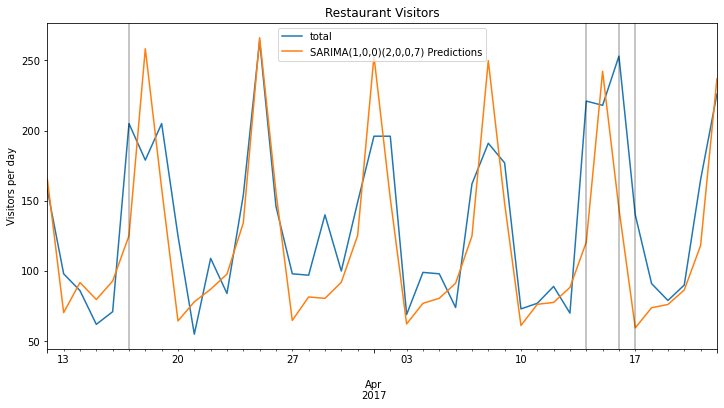

In [29]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Model Evaluation 

In [30]:
from statsmodels.tools.eval_measures import mse,rmse

error1 = mse(test['total'], predictions)
error2 = rmse(test['total'], predictions)

print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.629477
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26293103


### Adding the exogenous variable to improve model: 

In [31]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2158.730
Date:                           Wed, 18 Nov 2020   AIC                           4327.460
Time:                                   10:11:31   BIC                           4347.848
Sample:                               01-01-2016   HQIC                          4335.506
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       63.5880      4.157     15.298      0.000      55.441      71.735
ar.L1          0.2150      0.048      4.495      0.000       0.121       0.309
ar.S.L7        0.5146      0.041     12.587      0.000       0.434       0.595
ar.S.L14       0.4574      0.041     11.227      0.000       0.378       0.537
sigma2      1092.8696     70.160     15.577      0.000     955.358    1230.381
===================================================================================
Ljung-Box (Q):                       98.83   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.00   Prob(JB):                         0.48
Heteroskedasticity (H):               0.91   Skew:                             0.12
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Predictions')

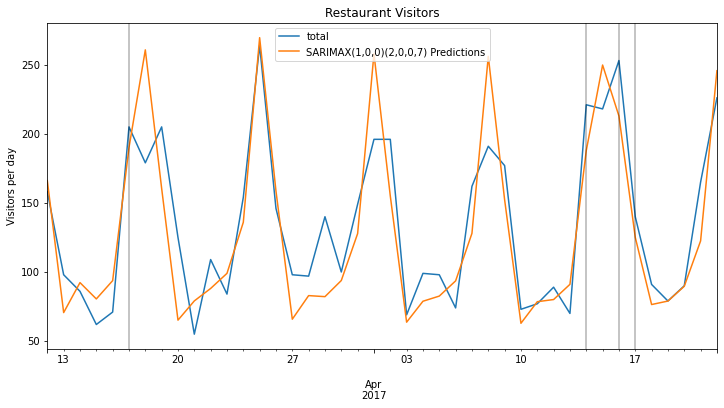

In [34]:
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

### Evaluating the model 

In [37]:
# Print values from SARIMA above
print(f'SARIMA(1,0,0)(2,0,0,7) MSE Error: {error1:11.10}')
print(f'SARIMA(1,0,0)(2,0,0,7) RMSE Error: {error2:11.10}')
print('\n')

error1x = mse(test['total'], predictions)
error2x = rmse(test['total'], predictions)

# Print new SARIMAX values
print(f'SARIMAX(1,0,0)(2,0,0,7) MSE Error: {error1x:11.10}')
print(f'SARIMAX(1,0,0)(2,0,0,7) RMSE Error: {error2x:11.10}')

SARIMA(1,0,0)(2,0,0,7) MSE Error: 1702.629477
SARIMA(1,0,0)(2,0,0,7) RMSE Error: 41.26293103


SARIMAX(1,0,0)(2,0,0,7) MSE Error: 965.5702335
SARIMAX(1,0,0)(2,0,0,7) RMSE Error: 31.07362601


As we can see, SARIMAX performed better than SARIMA model because of additional information about the holiday variable, which indicates spikes in the number of visitors in restaurants.

### Re-training the model on full data and predicting into the future 

In [ ]:
model = SARIMAX(df1['total'],exog=df1['holiday'],order=(1,0,0),seasonal_order=(2,0,0,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df[478:][['holiday']]
fcast = results.predict(len(df1),len(df1)+38,exog=exog_forecast).rename('SARIMAX(1,0,0)(2,0,0,7) Forecast')

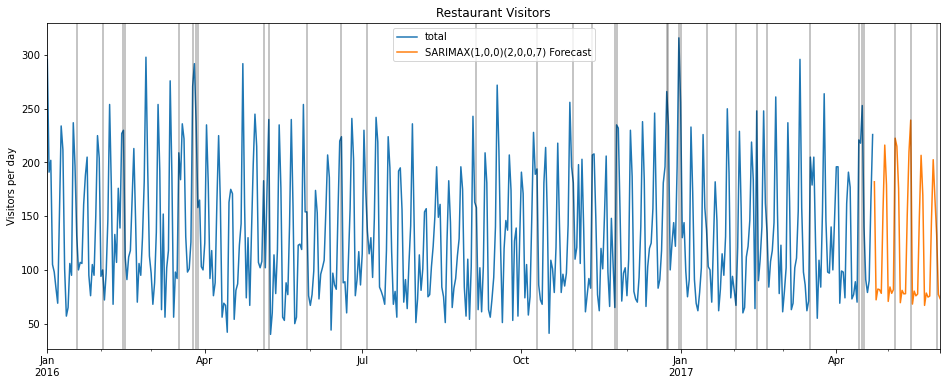

In [39]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel=''

ax = df1['total'].plot(legend=True,figsize=(16,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df.query('holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);